In [ ]:
!! pip install -U open-metric-learning

In [ ]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.models import ViTExtractor
from oml.utils.download_mock_dataset import download_mock_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("OML/")
import sqlite3

conn = sqlite3.connect('img/w_img.db')
cursor = conn.cursor()

# DF 타입 출력
import pandas as pd

cursor.execute("SELECT * FROM w_img;")
rows = cursor.fetchall()

cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)
conn.close()

In [ ]:
import pandas as pd

df_val = df[df['split'] == "validation"]
dataset_root = "img/WOMAN/"

In [ ]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 원하는 크기로 조정
    transforms.ToTensor(),  # 텐서로 변환
])

In [ ]:
model = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False).eval()
val_dataset = DatasetQueryGallery(df_val, dataset_root=dataset_root, transform=image_transform)
val_dataset.df

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


,label,path,split,is_query,is_gallery
15,5,img/WOMAN/Karina01.jpg,validation,1,0
16,5,img/WOMAN/Karina02.jpg,validation,0,1
17,5,img/WOMAN/Karina03.jpg,validation,0,1
18,6,img/WOMAN/Yuna01.jpeg,validation,1,0
19,6,img/WOMAN/Yuna02.jpeg,validation,0,1
20,6,img/WOMAN/Yuna03.jpeg,validation,0,1
21,7,img/WOMAN/seoryun01.jpg,validation,1,0
22,7,img/WOMAN/seoryun02.jpg,validation,0,1
23,7,img/WOMAN/seoryun03.jpg,validation,0,1


In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)
calculator = EmbeddingMetrics(extra_keys=["paths",])
calculator.setup(num_samples=len(val_dataset))

In [ ]:
with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = model(batch["input_tensors"])
        calculator.update_data(batch)

100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


In [ ]:
metrics = calculator.compute_metrics()


Metrics:
{'OVERALL': {'cmc': {5: tensor(1.)},
             'map': {5: tensor(0.5833)},
             'pcf': {0.5: tensor(0.0078)},
             'precision': {5: tensor(0.8333)}}}


In [ ]:
# Logging
print(calculator.metrics)  # metrics
print(calculator.metrics_unreduced)  # metrics without averaging over queries

{'OVERALL': {'cmc': {5: tensor(1.)}, 'precision': {5: tensor(0.8333)}, 'map': {5: tensor(0.5833)}, 'pcf': {0.5: tensor(0.0078)}}}
{'OVERALL': defaultdict(<class 'dict'>, {'cmc': {5: tensor([1., 1., 1.])}, 'precision': {5: tensor([0.5000, 1.0000, 1.0000])}, 'map': {5: tensor([0.2500, 0.7500, 0.7500])}, 'pcf': {0.5: tensor(0.0078)}})}


Draw predictions for predefined queries


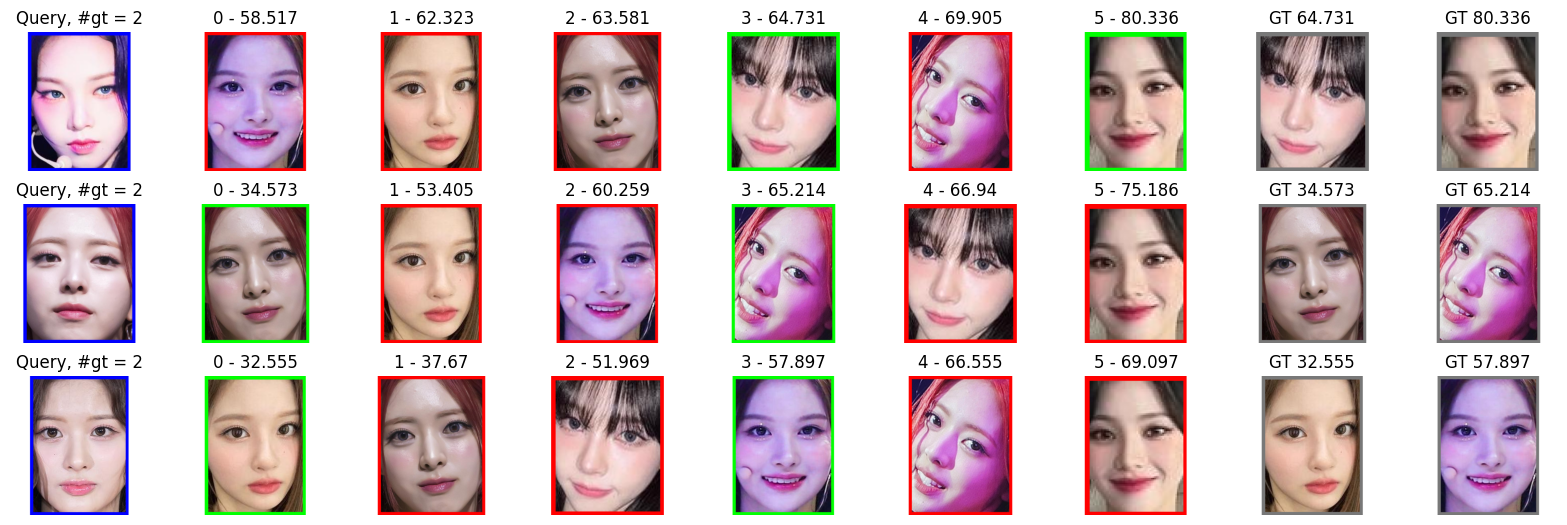

In [ ]:
import matplotlib.pyplot as plt

# Visualisation
print("Draw predictions for predefined queries")
calculator.get_plot_for_queries(query_ids=[0, 1, 2], n_instances=6, verbose=False)
plt.show()

Draw the queries worst by map@5


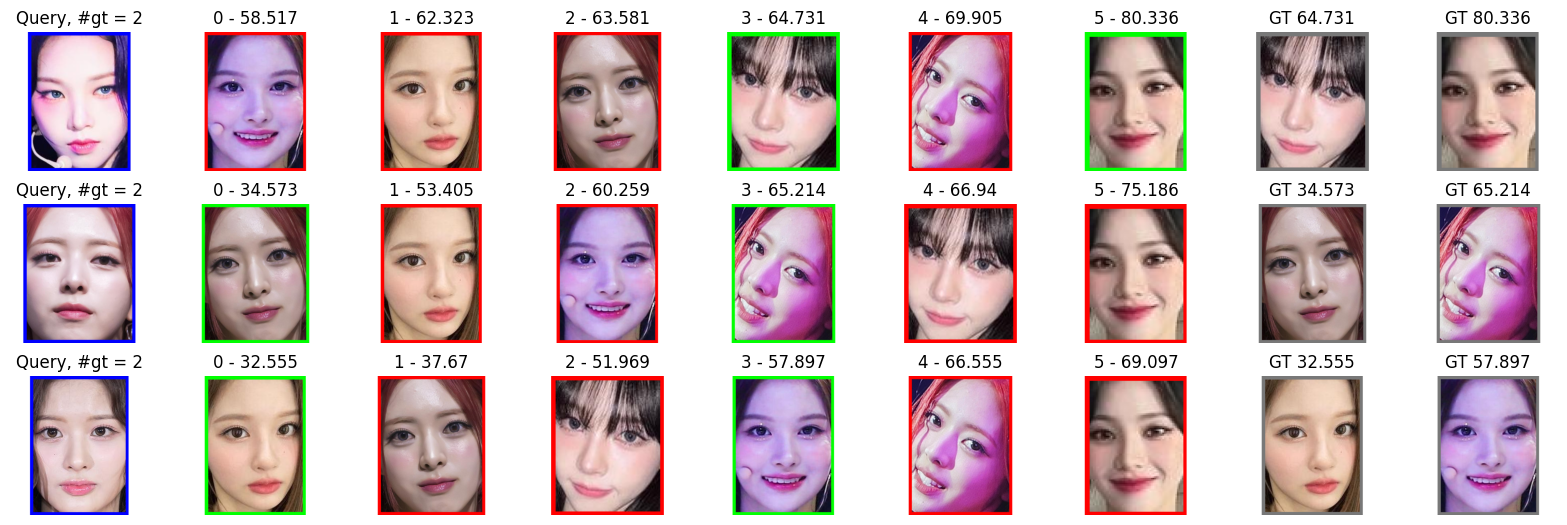

In [ ]:
print("Draw the queries worst by map@5")
calculator.get_plot_for_worst_queries(metric_name="OVERALL/map/5", n_queries=3, n_instances=6, verbose=False)
plt.show()

Q   img/WOMAN/Karina03.jpg
G 0 img/WOMAN/seoryun03.jpg
G 1 img/WOMAN/Yuna02.jpeg
G 2 img/WOMAN/seoryun02.jpg
G 3 img/WOMAN/seoryun01.jpg
G 4 img/WOMAN/Karina02.jpg
Q   img/WOMAN/Karina02.jpg
G 0 img/WOMAN/seoryun02.jpg
G 1 img/WOMAN/seoryun01.jpg
G 2 img/WOMAN/Yuna02.jpeg
G 3 img/WOMAN/seoryun03.jpg
G 4 img/WOMAN/Karina01.jpg


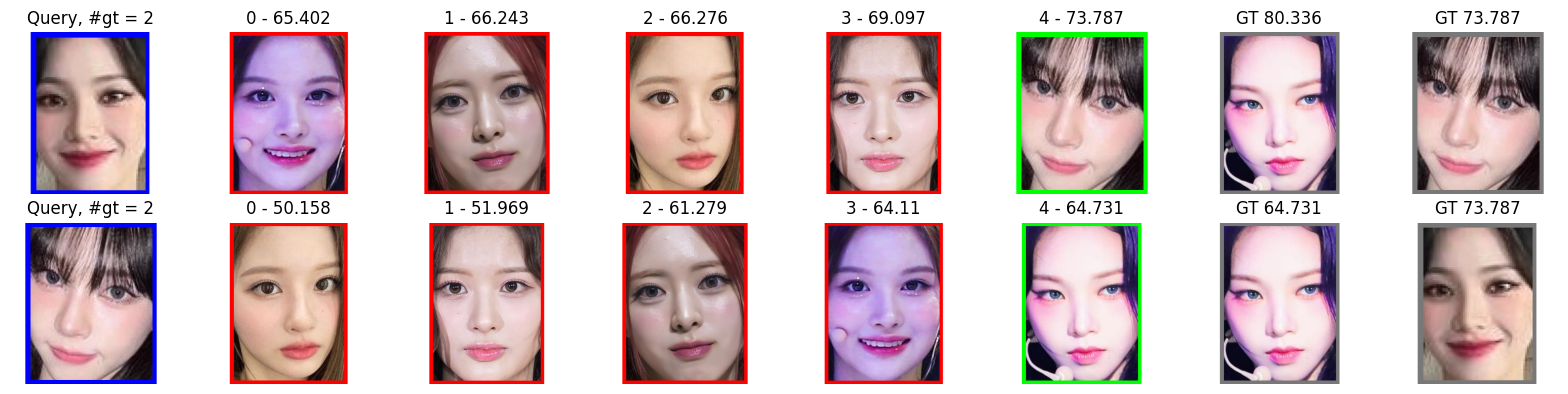

In [ ]:
calculator.get_plot_for_queries(query_ids=[2, 1], n_instances=5, verbose=True)
plt.show()